# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10214,16197,61149,NaN,21-03-2020,Missouri woman gives birth in the #toiletpaper...,Extremely Positive
793,4751,49703,NaN,17-03-2020,AR #COVID19 LATEST:\r\r\n@AsaHutchinson : Food...,Negative
18410,26197,71149,NaN,25-03-2020,Are you looking to stock up your stores or ref...,Extremely Positive
32386,43635,88587,NaN,13-04-2020,The average price of regular gas fell 14 cents...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [4]:
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,11422
Negative,9917
Extremely Positive,6624
Extremely Negative,5481


In [6]:
df['Sentiment_binary'] = df['Sentiment'].apply(
    lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0 if x in ['Negative', 'Extremely Negative'] else None)

df['Sentiment_binary'] = df['Sentiment_binary'].astype(int)

Сбалансированы ли классы?

In [7]:
df['Sentiment_binary'].value_counts()
print(df['Sentiment_binary'].value_counts(normalize=True)*100)

Sentiment_binary
1    53.958857
0    46.041143
Name: proportion, dtype: float64


**Ответ:**
классы сбалансированы, %-ое соотношение практически одинаковое

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [8]:
print(df.isnull().sum())
df = df.fillna('Unknown')
print('\n', df.isnull().sum())

UserName               0
ScreenName             0
Location            7049
TweetAt                0
OriginalTweet          0
Sentiment              0
Sentiment_binary       0
dtype: int64

 UserName            0
ScreenName          0
Location            0
TweetAt             0
OriginalTweet       0
Sentiment           0
Sentiment_binary    0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [9]:
from sklearn.model_selection import train_test_split

train, test =  train_test_split(
    df, test_size=0.3, random_state=0
)

train.reset_index(inplace=True)
test.reset_index(inplace=True)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [10]:
from collections import Counter

tokens = []
for text in train['OriginalTweet']:
    tokens.extend(word.lower() for word in text.split())

token_counts = Counter(tokens)

print(token_counts.most_common(10))

[('the', 26815), ('to', 23373), ('and', 14684), ('of', 13012), ('a', 11737), ('in', 11198), ('for', 8566), ('#coronavirus', 8223), ('is', 7383), ('are', 7050)]


Какой размер словаря получился?

In [11]:
print(len(token_counts))

79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [12]:
top10 = token_counts.most_common(10)
for token, count in top10:
    print(f"{token}: {count}")

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


**Ответ:**
самые частые слова — это функциональные словая, которые встречаются практически в каждом предложении. Они необходимы для построения конструкции предложений, а не для выражения основной смысловой нагрузки.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

token_counts_no_stop = Counter({token: count for token, count in token_counts.items()
                                if token not in stop_words})

top10_no_stop = token_counts_no_stop.most_common(10)
for token, count in top10_no_stop:
    print(f"{token}: {count}")

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Ответ:**  
датасает характеризует тематику продовольствия (магазины, супермаркеты и продовольствие) в короновирусные времена

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [14]:
least_common_20 = token_counts_no_stop.most_common()[::-1][:20]
for token, count in least_common_20:
    print(f"{token}: {count}")

https://t.co/7j2y3rsld9: 1
@680news: 1
@torontopearson: 1
nothing...: 1
flew: 1
wage!: 1
renewing: 1
playersãâ: 1
subsidise: 1
non-playing: 1
premiership: 1
https://t.co/iaek4fwsgz: 1
@srinivasiyc: 1
https://t.co/zjcl195vqs: 1
#southkerry: 1
#skelligcoast2kms: 1
@skelligsix18: 1
closer!): 1
coast!: 1
skellig: 1


**Ответ:**  эти токены соержат странные символы, а так же знаки препинания и служебные символы. Да, кажется что было бы неплохо очистить данные токены



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [15]:
from nltk.tokenize import TweetTokenizer

# -- YOUR CODE HERE --
tokenizer_2 = TweetTokenizer()

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2.tokenize(text.lower())
    tokens = [token for token in tokens]
    all_tokens.extend(tokens)

token_counts_tt = Counter(all_tokens)
top10_tt = token_counts_tt.most_common(10)
for token, count in top10_tt:
    print(f"{token}: {count}")

the: 26993
.: 24118
to: 23478
,: 17571
and: 14825
of: 13044
a: 11891
in: 11348
?: 9524
#coronavirus: 8808


**Ответ:**  В топе так же частицы и предлоги, но стали так же появляться и знаки препинания

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [16]:
punct = set(punctuation)

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2.tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in punct]
    all_tokens.extend(tokens)

counter = Counter(all_tokens)
top10 = counter.most_common(10)

for word, cnt in top10:
    print(f"{word}: {cnt}")

#coronavirus: 8808
â: 7415
: 7311
19: 7167
covid: 6253
prices: 4601
: 4372
food: 4367
store: 3877
supermarket: 3805


**Ответ:** Предлоги очистились, но все равно есть символы пунктуации и странные символы

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [17]:
def is_good_token(token):
    if token in stop_words or token in punct:
        return False
    if len(token) == 1 and ord(token) >= 128:
        return False
    return True

punct = set(punctuation)

all_tokens = []
for text in train['OriginalTweet']:
    tokens = tokenizer_2.tokenize(text.lower())
    tokens = [token for token in tokens if is_good_token(token)]
    all_tokens.extend(tokens)

counter = Counter(all_tokens)
top10 = counter.most_common(10)
bottom20 = counter.most_common()[-20:]

In [18]:
print('Топ 10 самых популярных слов:')
for word, cnt in top10:
    print(f"{word}: {cnt}")

Топ 10 самых популярных слов:
#coronavirus: 8808
19: 7167
covid: 6253
prices: 4601
food: 4367
store: 3877
supermarket: 3805
grocery: 3523
people: 3463
#covid19: 2589


In [19]:
print('Топ20 наименее популярных слов:')
for word, cnt in bottom20:
    print(f"{word}: {cnt}")

Топ20 наименее популярных слов:
https://t.co/lw1r0rm7xs: 1
https://t.co/5cbliqzx7l: 1
now.when: 1
milion: 1
skellig: 1
@skelligsix18: 1
#skelligcoast2kms: 1
#southkerry: 1
https://t.co/zjcl195vqs: 1
@srinivasiyc: 1
https://t.co/iaek4fwsgz: 1
premiership: 1
non-playing: 1
subsidise: 1
playersã: 1
renewing: 1
flew: 1
@torontopearson: 1
@680news: 1
https://t.co/7j2y3rsld9: 1


**Ответ:**  Топ слов выглядит уже более менее чисто и прилично, однако знаки @, # и ссылки кажется что тоже стоит очищать

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [20]:
hashtags = [token for token in all_tokens if token.startswith("#")]
hashtag_counter = Counter(hashtags)
top10_hashtags = hashtag_counter.most_common(10)

In [21]:
print('Топ10 популярных хештегов:')
for tag, count in top10_hashtags:
    print(f"{tag}: {count}")

Топ10 популярных хештегов:
#coronavirus: 8808
#covid19: 2589
#covid_19: 1734
#covid2019: 946
#toiletpaper: 744
#covid: 641
#socialdistancing: 465
#coronacrisis: 448
#pandemic: 257
#coronaviruspandemic: 249


**Ответ:** 8 из 10 хештегов относится к теме коронавируса, одна все они записаны по разному, без единой стандартизации

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [22]:
tco_links = [token for token in all_tokens if token.startswith("https://t.co")]
tco_counter = Counter(tco_links)
top10_tco = tco_counter.most_common(10)

In [23]:
print('Топ 10 ссылок на https://t.co:')
for link, count in top10_tco:
    print(f"{link}: {count}")

Топ 10 ссылок на https://t.co:
https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfãâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


**Ответ:** Популярность ссылок значительно ниже, чем у топовых хештегов. Информация о ссылке на конкретную страницу могла бы быть полезна, если бы их популярность была выше.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [24]:
def custom_tokenizer(text, punct=punctuation, stop_words=stop_words):

    text = text.lower()

    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    filtered_tokens = []
    for token in tokens:
        if token in stop_words:
            continue

        if all(char in punctuation for char in token):
            continue

        if len(token) == 1 and ord(token) >= 128:
            continue

        if token.startswith('https://t.co'):
            continue
        filtered_tokens.append(token)

    return filtered_tokens


In [25]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

45268


**Ответ:** Стал меньше примерно в 2 раза

Посмотрим на какой-нибудь конкретный твитт:

In [27]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 'Negative')

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [28]:
vec = cv.transform([train.iloc[ind]['OriginalTweet']])
vec_array = vec.toarray()[0]
nonzero = np.where(vec_array > 0)[0]
max_idx = nonzero[np.argmax(vec_array[nonzero])]
min_idx = nonzero[np.argmin(vec_array[nonzero])]

reverse_vocab = {v: k for k, v in cv.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print("Самый важный токен (встречается чаще всего):", most_important_token)
print("Самый неважный токен (встречается только 1 раз):", least_important_token)

Самый важный токен (встречается чаще всего): #coronavirusoutbreak
Самый неважный токен (встречается только 1 раз): #coronavirusoutbreak


**Ответ:** Самый важный токен и неважный оказались одинаковыми. Кажется что смотреть количество вхождений слова в текст - не самый надежный фактор важности.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf.fit(train['OriginalTweet'])
tfidf_vec = tfidf.transform([train.iloc[ind]['OriginalTweet']])
tfidf_arr = tfidf_vec.toarray()[0]

nonzero = np.where(tfidf_arr > 0)[0]
max_idx = nonzero[np.argmax(tfidf_arr[nonzero])]
min_idx = nonzero[np.argmin(tfidf_arr[nonzero])]

reverse_vocab = {v: k for k, v in tfidf.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print(f'Самый важный токен TF-IDF: {most_important_token}')
print(f'Самый неважный токен TF: {least_important_token}')

Самый важный токен TF-IDF: brainless
Самый неважный токен TF: food


**Ответ:**  Тут уже слова определяются лучше. Так как ориентируемся не только на количество попадания слова в данный текст, но и во все текста из обучающего датасета

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [30]:
train[train['OriginalTweet'].apply(lambda x: 'happy' in x) & (train['Sentiment_binary'] == 1)]

,index,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_binary
2,28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,Extremely Positive,1
764,24206,33394,78346,"Hanau, Deutschland",05-04-2020,Lately been happy with the crispr cas9 thing t...,Positive,1
2484,25561,35102,80054,United Kingdom,06-04-2020,"@Kal_Ajimal Hi Kal, if you have a booking and ...",Extremely Positive,1
3089,25085,34517,79469,United States,06-04-2020,Are u up for the challenge? LetÃÂs do this. ...,Positive,1
3106,31956,43106,88058,"Oconto Falls, WI",12-04-2020,Got this sticker with my @ZaturalHemp order of...,Extremely Positive,1
...,...,...,...,...,...,...,...,...
22132,12629,19108,64060,Unknown,22-03-2020,So many clients happy they can go basically bu...,Extremely Positive,1
22799,29459,39962,84914,Shenzhen,09-04-2020,#covid19 #coronavirus prevention 75% Alcohol ...,Extremely Positive,1
22858,31311,42319,87271,USA,11-04-2020,We are happy to announce that SwabTek has part...,Extremely Positive,1
23201,16363,23724,68676,"Phoenix, AZ",24-03-2020,We have made every effort to stay prepared! Ch...,Extremely Positive,1


In [31]:
train.iloc[23241]['OriginalTweet']

'I cannot even see the supermarket door and IÃ\x82Â\x92m happy for it. I couldnÃ\x82Â\x92t imagine that 3 weeks ago, how the things change... How this #Covid_19 is going to change the society I donÃ\x82Â\x92t know, but I beleive weÃ\x82Â\x92ll be better human beings ? https://t.co/DyWjgfngut'

In [32]:
tfidf_vec = tfidf.transform([train.iloc[23241]['OriginalTweet']])
tfidf_arr = tfidf_vec.toarray()[0]

nonzero = np.where(tfidf_arr > 0)[0]
max_idx = nonzero[np.argmax(tfidf_arr[nonzero])]
min_idx = nonzero[np.argmin(tfidf_arr[nonzero])]

reverse_vocab = {v: k for k, v in tfidf.vocabulary_.items()}
most_important_token = reverse_vocab[max_idx]
least_important_token = reverse_vocab[min_idx]

print(f'Самый важный токен TF-IDF: {most_important_token}')
print(f'Самый неважный токен TF: {least_important_token}')

Самый важный токен TF-IDF: change
Самый неважный токен TF: supermarket


**Ответ:**  Человек рассуждает об тех изменениях, что ковид превнес в нашу жизнь... то что он смотрит на дверь супермаркета - действительно кажется не основной частью текста)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [33]:
vec_train = cv.fit_transform(train['OriginalTweet'])
vec_test = cv.transform(test['OriginalTweet'])

tfidf_vec_train = tfidf.fit_transform(train['OriginalTweet'])
tfidf_vec_test = tfidf.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)


lr_2 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_2.fit(tfidf_vec_train, train[target])
train_pred_tfidf = lr_2.predict(tfidf_vec_train)
test_pred_tfidf = lr_2.predict(tfidf_vec_test)
acc_train_tfidf = accuracy_score(train[target], train_pred_tfidf)
acc_test_tfidf = accuracy_score(test[target], test_pred_tfidf)

In [35]:
print(f'CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}')
print(f'TFIDFVectorizer:   Train accuracy = {acc_train_tfidf}, Test accuracy = {acc_test_tfidf}')

CountVectorizer:   Train accuracy = 0.9842375053395984, Test accuracy = 0.8672513454255532
TFIDFVectorizer:   Train accuracy = 0.9258009397693293, Test accuracy = 0.8544947179589396


**Ответ:**  CountVectorizer дает прирост к качеству относительно TFIDFVectorizer. Также мы получили небольшой оверфит из за того что есть разница в точности между треином и тестом, но она не сильно критична.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [36]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def custom_stem_tokenizer(text, punct=punctuation,
                          stop_words=stop_words, stemmer=stemmer):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    filtered_tokens = []
    for token in tokens:
        if token in stop_words:
            continue

        if all(char in punctuation for char in token):
            continue

        if len(token) == 1 and ord(token) >= 128:
            continue

        if token.startswith('https://t.co'):
            continue

        token = stemmer.stem(token)
        filtered_tokens.append(token)
    return filtered_tokens

In [37]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [38]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [39]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)

cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

36612


**Ответ** Уменьшился еще примерно на 25%


Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf.fit_transform(train['OriginalTweet'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 441290 stored elements and shape (23410, 45268)>

In [41]:
vec_train = cv.fit_transform(train['OriginalTweet'])
vec_test = cv.transform(test['OriginalTweet'])

tfidf_vec_train = tfidf.fit_transform(train['OriginalTweet'])
tfidf_vec_test = tfidf.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)


lr_2 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_2.fit(tfidf_vec_train, train[target])
train_pred_tfidf = lr_2.predict(tfidf_vec_train)
test_pred_tfidf = lr_2.predict(tfidf_vec_test)
acc_train_tfidf = accuracy_score(train[target], train_pred_tfidf)
acc_test_tfidf = accuracy_score(test[target], test_pred_tfidf)

In [46]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")
print(f"TFIDFVectorizer:   Train accuracy = {acc_train_tfidf}, Test accuracy = {acc_test_tfidf}")

CountVectorizer:   Train accuracy = 0.9719777872703973, Test accuracy = 0.8670520231213873
TFIDFVectorizer:   Train accuracy = 0.9258009397693293, Test accuracy = 0.8544947179589396


**Ответ:**   Качество не изменилось, а матрицы уменьшились - явный плюс, можно использовать стемминг для уменьшения размерности.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [47]:
df_counts = np.asarray((cv.fit_transform(train['OriginalTweet']) > 0).sum(axis=0)).ravel()
num_docs = cv.fit_transform(train['OriginalTweet']).shape[0]

In [48]:
sorted_df = np.sort(df_counts)
cutoff_df = sorted_df[-2]
max_df = cutoff_df / num_docs

In [50]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

36611


In [52]:
max_df

np.float64(0.29837676206749253)

**Ответ:** Значение 0.298 означает, что мы исключаем токены, которые встречаются в более чем в примерно 30% документов. Это связано с тем, что у нас почти нет токенов, которые встречаются более чем в трети документов

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [53]:
sorted_df = np.sort(df_counts)
min_df= sorted_df[-3680] / num_docs

In [54]:
min_df

np.float64(0.0004698846646732166)

In [55]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=min_df).fit(train['OriginalTweet'])
print(len(cv_df.vocabulary_))

3682


In [56]:
vec_train = cv_df.fit_transform(train['OriginalTweet'])
vec_test = cv_df.transform(test['OriginalTweet'])

target = ['Sentiment_binary']

In [57]:
lr_1 = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_1.fit(vec_train, train[target])
train_pred_count = lr_1.predict(vec_train)
test_pred_count = lr_1.predict(vec_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)

In [58]:
print(f"CountVectorizer:   Train accuracy = {acc_train_count}, Test accuracy = {acc_test_count}")

CountVectorizer:   Train accuracy = 0.9291328492097394, Test accuracy = 0.8681482957942994


**Ответ:** Размерность также уменьшилась, а качество сохранилось - хорошо.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
vec_train_scaled = scaler.fit_transform(vec_train)
vec_test_scaled = scaler.transform(vec_test)

lr_scaled = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')

lr_scaled.fit(vec_train_scaled, train[target])
train_pred_count = lr_scaled.predict(vec_train_scaled)
test_pred_count = lr_scaled.predict(vec_test_scaled)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)

In [61]:
print(f'Train Accuracy: {acc_train_count}')
print(f'Test Accuracy: {acc_test_count}')

Train Accuracy: 0.9411362665527553
Test Accuracy: 0.8450269085110624


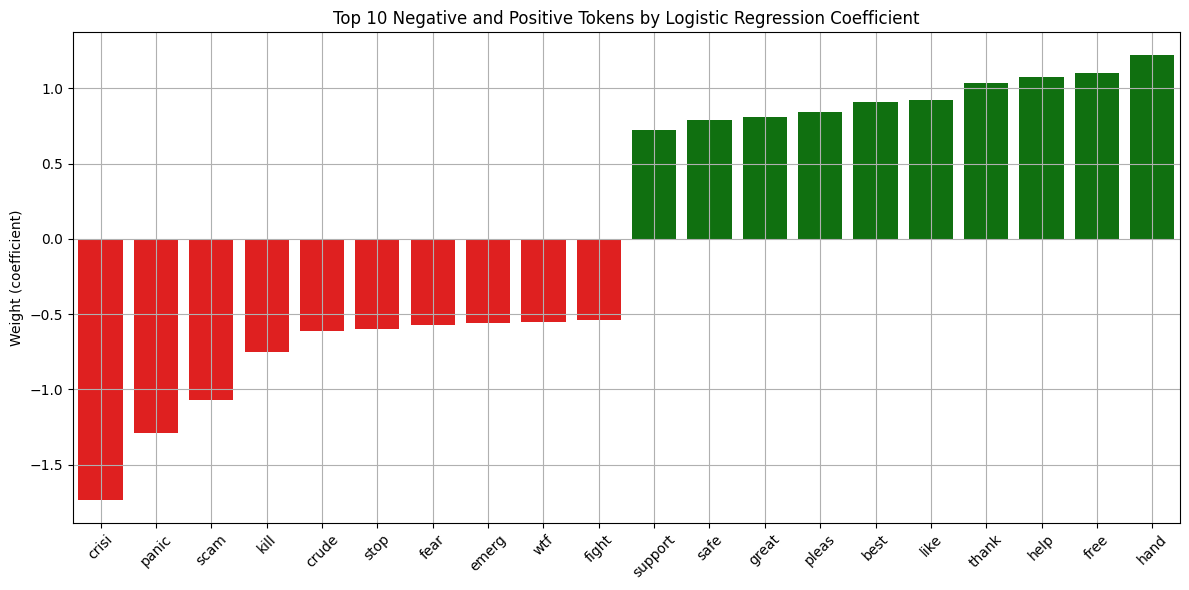

In [62]:
feature_names = np.array(cv_df.get_feature_names_out())
coef = lr_scaled.coef_.flatten()

top_pos_indices = np.argsort(coef)[-10:]
top_neg_indices = np.argsort(coef)[:10]

top_tokens = np.concatenate([feature_names[top_neg_indices], feature_names[top_pos_indices]])
top_weights = np.concatenate([coef[top_neg_indices], coef[top_pos_indices]])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_tokens, y=top_weights, palette=["red"]*10 + ["green"]*10)
plt.title("Top 10 Negative and Positive Tokens by Logistic Regression Coefficient")
plt.xticks(rotation=45)
plt.ylabel("Weight (coefficient)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Ответ:** Сами токены (слова) довольно логично вписываются в контекст соответствующего сентимента, например для негативных (kill, scam, wtf, etc.). Качество с заскейленными признаками вырастает на несколько пунктов и на трейне и на тесте

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [63]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_binary
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
2,3802,48754,Unknown,16-03-2020,My food stock is not the only one which is emp...,Positive,1


In [64]:
print('UserName уникальных:', df['UserName'].nunique())
print('ScreenName уникальных:', df['ScreenName'].nunique())
print('Размер датасета:', len(df))

UserName уникальных: 33444
ScreenName уникальных: 33444
Размер датасета: 33444


**Ответ:** Все значения уникальны -> неинформативны -> нет смысла кодировать

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [65]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)
test['TweetAt'] = pd.to_datetime(test['TweetAt'], dayfirst=True)

<Figure size 1200x600 with 0 Axes>

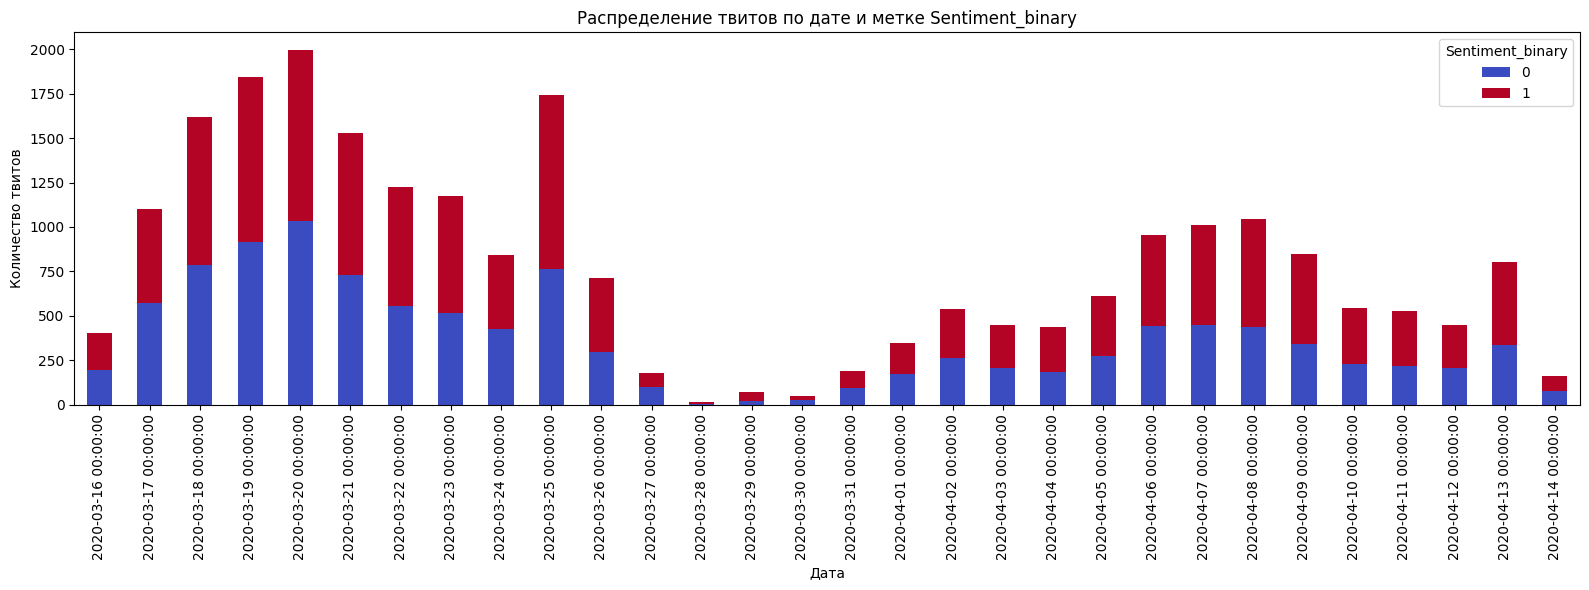

In [66]:
plt.figure(figsize=(12, 6))
train.groupby(['TweetAt', 'Sentiment_binary']).size().unstack().plot(kind='bar', stacked=True, figsize=(16, 6), colormap='coolwarm')
plt.title('Распределение твитов по дате и метке Sentiment_binary')
plt.xlabel('Дата')
plt.ylabel('Количество твитов')
plt.tight_layout()
plt.show()

In [67]:
train['date_ord'] = train['TweetAt'].map(lambda x: x.toordinal())
test['date_ord'] = test['TweetAt'].map(lambda x: x.toordinal())

In [68]:
from scipy.sparse import hstack

scaler_date = StandardScaler()
train_date_scaled = scaler_date.fit_transform(train[['date_ord']])
test_date_scaled = scaler_date.transform(test[['date_ord']])

X_train = hstack([vec_train_scaled, train_date_scaled])
X_test = hstack([vec_test_scaled, test_date_scaled])

In [69]:
lr_scaled_wide = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_scaled_wide.fit(X_train, train['Sentiment_binary'])


train_pred_count = lr_scaled_wide.predict(X_train)
test_pred_count = lr_scaled_wide.predict(X_test)
acc_train_count = accuracy_score(train[target], train_pred_count)
acc_test_count = accuracy_score(test[target], test_pred_count)

In [70]:
print('Train Accuracy:', acc_train_count)
print('Test Accuracy:', acc_test_count)

Train Accuracy: 0.9411789833404528
Test Accuracy: 0.8448275862068966


**Ответ:** Качество не сильно изменилось, но это логично, т.к. в целом кол-во позитивных и негативных твитов одинаково сбалансировано почти по всем дням



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [71]:
print('Уникальных значений в Location:', train['Location'].nunique())

Уникальных значений в Location: 7949


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

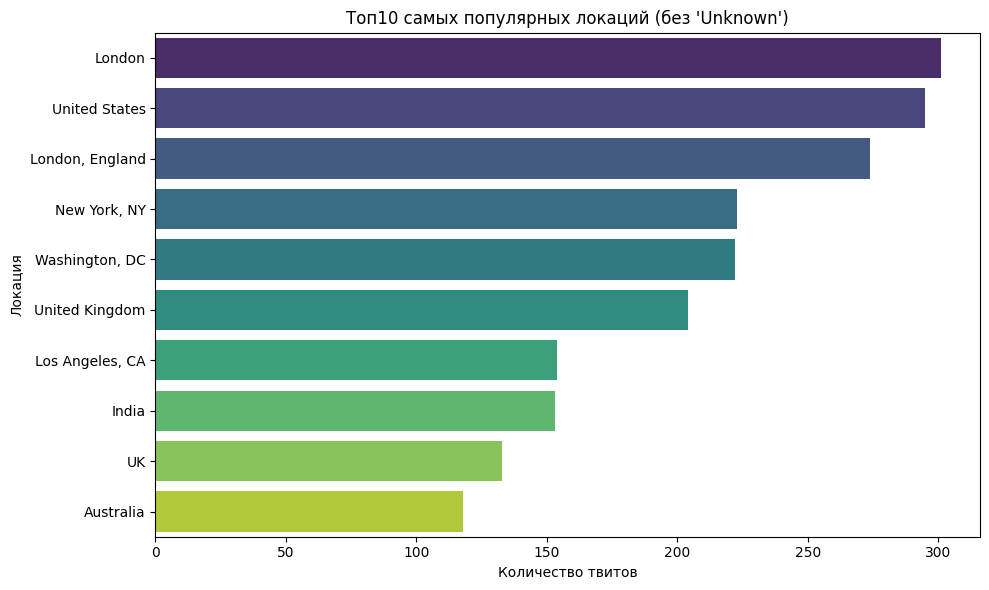

In [72]:
location_counts = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette="viridis")
plt.title("Топ10 самых популярных локаций (без 'Unknown')")
plt.xlabel("Количество твитов")
plt.ylabel("Локация")
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [73]:
train['WiderLocation'] = (train['Location'].fillna('Unknown').apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else 'Unknown'))
test['WiderLocation'] = (test['Location'].fillna('Unknown').apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else 'Unknown'))

print('Уникальных WiderLocation:', train['WiderLocation'].nunique())

Уникальных WiderLocation: 4631


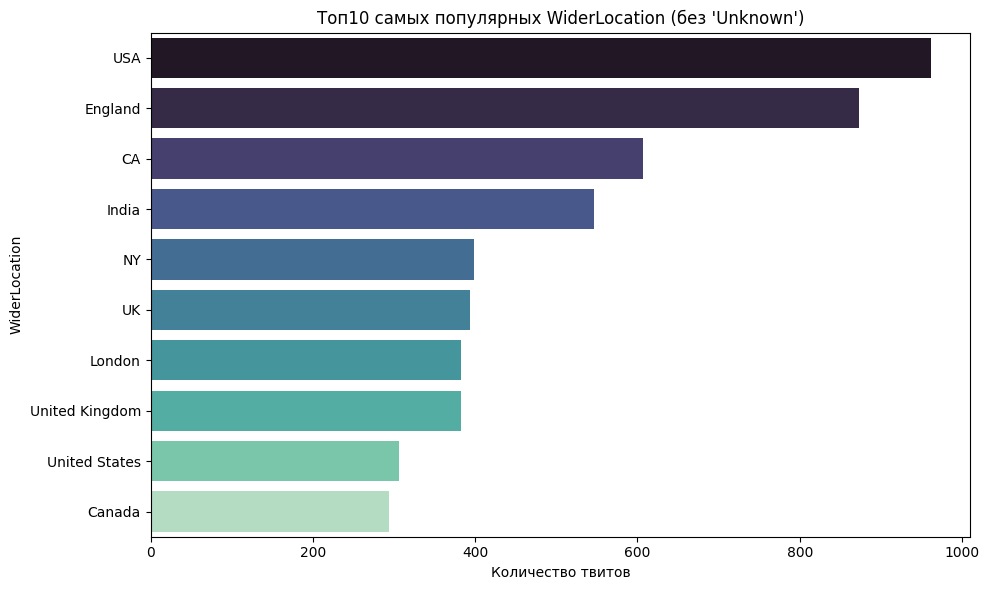

In [74]:
top_wider_locations = (train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_wider_locations.values, y=top_wider_locations.index, palette="mako")
plt.title("Топ10 самых популярных WiderLocation (без 'Unknown')")
plt.xlabel("Количество твитов")
plt.ylabel("WiderLocation")
plt.tight_layout()
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [75]:
from sklearn.preprocessing import OneHotEncoder

counts = train['WiderLocation'].value_counts()
frequent_locations = counts[counts > 1].index.tolist()

train['WiderLocation_filtered'] = train['WiderLocation'].where(train['WiderLocation'].isin(frequent_locations))


ohe = OneHotEncoder(handle_unknown='ignore')
wl_ohe = ohe.fit_transform(train[['WiderLocation_filtered']])

In [76]:
print(f'Уникальных WiderLocation с частотой > 1 (OHE): {wl_ohe.shape[1]}')

Уникальных WiderLocation с частотой > 1 (OHE): 989


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [78]:
counts = train['WiderLocation'].value_counts()
frequent_locations = counts[counts > 1].index.tolist()

train['WiderLocation_filtered'] = train['WiderLocation'].where(train['WiderLocation'].isin(frequent_locations))
test['WiderLocation_filtered'] = test['WiderLocation'].where(test['WiderLocation'].isin(frequent_locations))

ohe = OneHotEncoder(categories=[frequent_locations], handle_unknown='ignore')

wl_ohe_train = ohe.fit_transform(train[['WiderLocation_filtered']])
wl_ohe_test = ohe.transform(test[['WiderLocation_filtered']])

X_train = hstack([vec_train, wl_ohe_train])
X_test = hstack([vec_test, wl_ohe_test])

lr_wl = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
lr_wl.fit(X_train, train[target])

train_pred = lr_wl.predict(X_train)
test_pred = lr_wl.predict(X_test)

acc_train = accuracy_score(train[target], train_pred)
acc_test = accuracy_score(test[target], test_pred)

In [79]:
print(f"Train accuracy с WiderLocation OHE: {acc_train}")
print(f"Test accuracy с WiderLocation OHE: {acc_test}")

Train accuracy с WiderLocation OHE: 0.9323793250747544
Test accuracy с WiderLocation OHE: 0.8666533785130556


**Ответ:** Качество слегка просело, это говорит о том, что признак локации не добавляет модели никакой обобщающей способнсти.